# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
from scipy import spatial, sparse

In [3]:
data = pd.read_csv('D:/wildfires/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
data2015 = data[data.FIRE_YEAR == 2015]

In [5]:
def get_A(data, dist, blocksize=10000):
    
    print("Setting up...")
    values = np.array(data.values)
    
    # Dimensions should be be (N, K), even if K = 1 columns. Reshape if needed
    if len(values.shape) == 1:
        values = values.reshape((values.shape[0], 1))
    N = values.shape[0]
        
    print("Initializing sparse matrix...")
    # Initialize sparse matrix
    A = sparse.lil_matrix((N,N))
    
    # Divide-and-conquer: split the overall big adjacency matrix into
    # blocksize x blocksize chunks, then use scipy's super-fast C implementation for distance matrix
    for i in range(N // blocksize):
        for j in range(i, N // blocksize):
            
            print((i,j))
            
            # Make sure we don't go out of bounds if N isn't divisible by blocksize!
            row_start = i * blocksize
            row_end   = min((i+1) * blocksize, N-1)
            col_start = j * blocksize
            col_end   = min((j+1) * blocksize, N-1)
            
            # Get the relevant values for this block
            #print("Get row/col vals")
            row_values = values[row_start:row_end, :]
            col_values = values[col_start:col_end, :]
            
            # Get distance matrix for this block
            #print("Calculate distance")
            D = spatial.distance.cdist(row_values, col_values)
            
            # Threshold it
            #print("Threshold it")
            subA = D <= dist
            
            # Insert into matrix
            #print("Insert into matrix")
            A[row_start:row_end, col_start:col_end] = subA
            
            # This graph is undirected--A will be symmetric! So set the other side now
            if i != j:
                #print("Insert into matrix, transposed")
                A[col_start:col_end, row_start:row_end] = subA.T
            
    # Convert to CSR format for fast arithmetic
    #print("Convert CSR")
    A = A.tocsr()
            
    return A

In [6]:
attr_time = data2015[["DISCOVERY_DOY"]]
attr_space = data2015[["LATITUDE", "LONGITUDE"]]

In [7]:
gc.collect()

2511

# Using time
Threshold = 1 day

In [8]:
%%time
Atime = get_A(attr_time, 1.01, blocksize=20000)

Setting up...
Initializing sparse matrix...
(0, 0)
(0, 1)
(0, 2)
(1, 1)
(1, 2)
(2, 2)
Wall time: 5min 43s


### Degree distribution

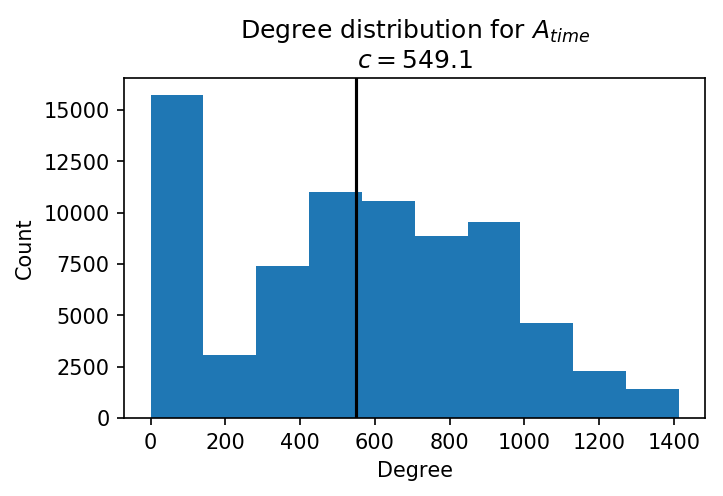

In [9]:
deg = Atime.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{time}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Using space
Threshold = 1$^\circ$ radius

In [10]:
%%time
Aspace = get_A(attr_space, 1.0, blocksize=20000)

Setting up...
Initializing sparse matrix...
(0, 0)
(0, 1)
(0, 2)
(1, 1)
(1, 2)
(2, 2)
Wall time: 5min 14s


### Degree distribution

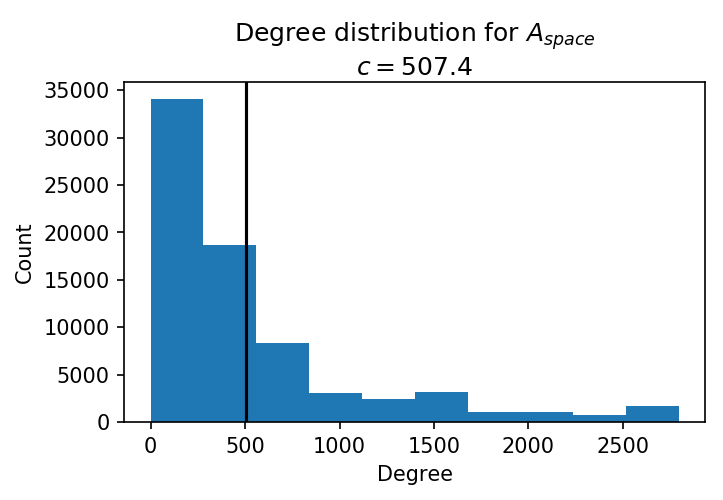

In [11]:
deg = Aspace.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{space}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Using both
Threshold: only if edge meets **both** criteria

In [14]:
%%time
Aboth = Aspace.multiply(Atime)

Wall time: 356 ms


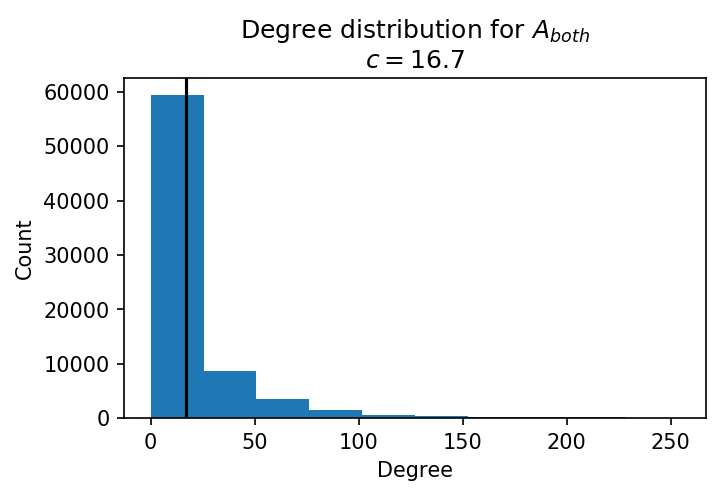

In [15]:
deg = Aboth.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Save sparse matrices to disk

In [ ]:
with open('Atime.pkl', 'wb') as f:
    pickle.dump(Atime, f)
    
with open('Aspace.pkl', 'wb') as f:
    pickle.dump(Aspace, f)

with open('Aboth.pkl', 'wb') as f:
    pickle.dump(Aboth, f)